# Imports and installs

In [1]:
#pip install tensorflow

In [2]:
import pandas as pd
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import numpy as np
import xgboost as xgb
import sklearn
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import sklearn
import shap
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from keras.callbacks import LearningRateScheduler

/home/joaosantos/.pyenv/versions/3.8.12/envs/OnThePitch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-06-06 14:37:49.085387: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-06 14:37:49.204858: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-06 14:37:49.204886: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Loading the Dataframe

In [3]:
def get_data(league1, wall=False):
    
    if wall:
        data = pd.DataFrame()
        leagues = listdir(f'./../raw_data/')
        data = pd.DataFrame()
        for league in leagues:
            files = listdir(f'./../raw_data/{league}')
            for file in files:
                df = pd.read_csv((f'./../raw_data/{league}/'+file))
                df['country']=str(file)[0:2]
                data = pd.concat([data, df])

        return data
    
    else:
        files = [file for file in listdir(f'./../raw_data/{league1}')]
        data = pd.DataFrame()

        for file in files:
            df = pd.read_csv(f'./../raw_data/{league1}/'+file)
            data = pd.concat([data, df])

        return data

In [4]:
data = get_data('italy', wall=True)

# Features Engineering

In [59]:
#Loading the function

def feature_engineering(data, b=20, binned=False):
    '''
    This function creates all the columns that will be needed to create the analysis 
    and return the dataframe with all this changes
    
    b is the number of bins that we want to work with. Our start value for b will be 20.
        '''
    #------------------------Number of Goals, Over and Under -----------------------------------
    
    # total number of goals = goals from the home team + goals from visiting team
    data['nb_goals']=data['FTHG']+data['FTAG']

    # boolean: true or false regarding whether they were more than 2.5 goals
    data['over_2.5_goals']=data['nb_goals']>2.5

    # boolean: true or false regarding whether they were less than 2.5 goals
    data['under_2.5_goals']=data['nb_goals']<2.5
    
    #-----------------------------Payout Opening ----------------------------------------------
    
    # payout under 2.5 for Average OPENING odds
    data['payout_avg_under_2.5'] = data['under_2.5_goals']*data['Avg<2.5']

    # payout over 2.5 for Average OPENING odds
    data['payout_avg_over_2.5'] = data['over_2.5_goals']*data['Avg>2.5']

    #payout UNDER 2.5 for PINACLE specifically
    data['payout_under_2.5_pinacle'] = data['under_2.5_goals']*data['P<2.5']

    #payout OVER 2.5 for PINACLE specifically
    data['payout_over_2.5_pinacle'] = data['over_2.5_goals']*data['P>2.5']

    #payout UNDER 2.5 for 365 specifically
    data['payout_under_2.5_365'] = data['under_2.5_goals']*data['B365<2.5']

    #payout OVER 2.5 for 365 specifically
    data['payout_over_2.5_365'] = data['over_2.5_goals']*data['B365>2.5']
    
    #------------------------------Payout Closing --------------------------------------------
    
    # payout under 2.5 for Average CLOSING odds
    data['payout_avg_under_closing_2.5'] = data['under_2.5_goals']*data['AvgC<2.5']

    # payout over 2.5 for Average CLOSING odds
    data['payout_avg_over_closing_2.5'] = data['over_2.5_goals']*data['AvgC>2.5']

    #payout UNDER 2.5 for PINACLE closing ddds specifically
    data['payout_under_2.5_pinacle_closing'] = data['under_2.5_goals']*data['PC<2.5']

    #payout OVER 2.5 for PINACLE closing odds specifically
    data['payout_over_2.5_pinacle_closing'] = data['over_2.5_goals']*data['PC>2.5']

    #payout UNDER 2.5 for 365 closing odds specifically
    data['payout_under_2.5_365_closing'] = data['under_2.5_goals']*data['B365C<2.5']

    #payout OVER 2.5 for 365 closing odds specifically
    data['payout_over_2.5_365_closing'] = data['over_2.5_goals']*data['B365C>2.5']
    
    #-------------------------- Implied Probability Opening ----------------------------------------
    
    #Implied Probability UNDER 2.5 goals for for overall market opening odds (Avg) 
    data['Implied Probability <2.5 avg']=1/data['Avg<2.5']*100

    #Implied Probability OVER 2.5 goals for for overall market opening odds (Avg) 
    data['Implied Probability >2.5 avg']=1/data['Avg>2.5']*100

    #Implied Probability UNDER 2.5 goals for PINACLE
    data['Implied Probability <2.5 pinacle']=1/data['P<2.5']*100

    #Implied Probability OVER 2.5 goals for PINACLE
    data['Implied Probability >2.5 pinacle']=1/data['P>2.5']*100

    #Implied Probability UNDER 2.5 goals for 365
    data['Implied Probability <2.5 365']=1/data['B365<2.5']*100

    #Implied Probability OVER 2.5 goals for 365
    data['Implied Probability >2.5 365']=1/data['B365>2.5']*100
    
    #------------------------- Implied Probability Closing -----------------------------------
    
    #Implied Probability UNDER 2.5 goals for overall market closing odds (AvgC)
    data['Implied Probability <2.5 avg closing']=1/data['AvgC<2.5']*100

    #Implied Probability OVER 2.5 goals for overall market closing odds (AvgC)
    data['Implied Probability >2.5 avg closing']=1/data['AvgC>2.5']*100

    #Implied Probability UNDER 2.5 goals for PINACLE closing odds
    data['Implied Probability <2.5 pinacle closing']=1/data['PC<2.5']*100

    #Implied Probability OVER 2.5 goals for PINACLE closing odds
    data['Implied Probability >2.5 pinacle closing']=1/data['PC>2.5']*100

    #Implied Probability UNDER 2.5 goals for 365 closing odds
    data['Implied Probability <2.5 365 closing']=1/data['B365C<2.5']*100

    #Implied Probability OVER 2.5 goals for 365 closing odds
    data['Implied Probability >2.5 365 closing']=1/data['B365C>2.5']*100
    
    #---------------------------- Binning IP Opening -------------------------------------

    b=b
    bins = np.arange(0, 101, int(100/b))
    bins = bins.tolist()

    #Binning UNDER 2.5 Average Market opening odds
    data['binned <2.5 avg'] = pd.cut(data['Implied Probability <2.5 avg'], bins)

    #Binning Over 2.5 Average Market opening odds
    data['binned >2.5 avg'] = pd.cut(data['Implied Probability >2.5 avg'], bins)

    #Binned UNDER 2.5 Pinnacle opening odds
    data['binned <2.5 pinacle'] = pd.cut(data['Implied Probability <2.5 pinacle'], bins)

    #Binned OVER 2.5 Pinnacle
    data['binned >2.5 pinacle'] = pd.cut(data['Implied Probability >2.5 pinacle'], bins)

    #Binned UNDER 2.5 bet365 OPENING odds
    data['binned <2.5 365'] = pd.cut(data['Implied Probability <2.5 365'], bins)

    #Binned OVER 2.5 bet365 OPENING odds
    data['binned >2.5 365'] = pd.cut(data['Implied Probability >2.5 365'], bins)
    
    #----------------------------- Binning IP Closing ------------------------------------------------

    #Binning UNDER 2.5 Average Market closing odds
    data['binned <2.5 avg closing'] = pd.cut(data['Implied Probability <2.5 avg closing'], bins)

    #Binning OVER 2.5 Average Market closing odds
    data['binned >2.5 avg closing'] = pd.cut(data['Implied Probability >2.5 avg closing'], bins)

    #Binned UNDER 2.5 Pinnacle closing odds
    data['binned <2.5 pinacle closing'] = pd.cut(data['Implied Probability <2.5 pinacle closing'], bins)

    #Binned OVER 2.5 Pinnacle CLOSING odds
    data['binned >2.5 pinacle closing'] = pd.cut(data['Implied Probability >2.5 pinacle closing'], bins)

    #Binned UNDER 2.5 bet365 CLOSING odds
    data['binned <2.5 365 closing'] = pd.cut(data['Implied Probability <2.5 365 closing'], bins)

    #Binned OVER 2.5 bet365 CLOSING odds
    data['binned >2.5 365 closing'] = pd.cut(data['Implied Probability >2.5 365 closing'], bins)
    
    #---------------------------- Binning Odds Opening ----------------------------------------------------
    
    bins2 = [1, 1.5, 2, 3, 99999]

    #Binning UNDER 2.5 Average Market opening odds
    data['binned odds <2.5 avg'] = pd.cut(data['Avg<2.5'], bins2)

    #Binning Over 2.5 Average Market opening odds
    data['binned odds >2.5 avg'] = pd.cut(data['Avg>2.5'], bins2)

    #Binned UNDER 2.5 Pinnacle opening odds
    data['binned odds <2.5 pinacle'] = pd.cut(data['P<2.5'], bins2)

    #Binned OVER 2.5 Pinnacle
    data['binned odds >2.5 pinacle'] = pd.cut(data['P>2.5'], bins2)

    #Binned UNDER 2.5 bet365 OPENING odds
    data['binned odds <2.5 365'] = pd.cut(data['B365<2.5'], bins2)

    #Binned OVER 2.5 bet365 OPENING odds
    data['binned odds >2.5 365'] = pd.cut(data['B365>2.5'], bins2)
    
    #----------------------------- Binning Odds Closing ----------------------------------------------------------
    
    #Binning UNDER 2.5 Average Market opening odds
    data['binned odds <2.5 avg closing'] = pd.cut(data['AvgC<2.5'], bins2)

    #Binning Over 2.5 Average Market opening odds
    data['binned odds >2.5 avg closing'] = pd.cut(data['AvgC>2.5'], bins2)

    #Binned UNDER 2.5 Pinnacle opening odds
    data['binned odds <2.5 pinacle closing'] = pd.cut(data['PC<2.5'], bins2)

    #Binned OVER 2.5 Pinnacle
    data['binned odds >2.5 pinacle closing'] = pd.cut(data['PC>2.5'], bins2)

    #Binned UNDER 2.5 bet365 OPENING odds
    data['binned odds <2.5 365 closing'] = pd.cut(data['B365C<2.5'], bins2)

    #Binned OVER 2.5 bet365 OPENING odds
    data['binned odds >2.5 365 closing'] = pd.cut(data['B365C>2.5'], bins2)
    
    
    #----------------------------- Other Features from D3 ------------------------------------------------------
    
    data['Pin_pays_better_under_boolean'] = data['PC<2.5'] > data['AvgC<2.5']
    data['Pin_pays_better_under_difference'] = data['PC<2.5'] / data['AvgC<2.5']
    data['%vig_p'] = (1 - (1 / (1/data['PC>2.5'] + 1/data['PC<2.5'])))*100
    data['%vig_avg'] = (1 - (1 / (1/data['AvgC>2.5'] + 1/data['AvgC<2.5'])))*100
    data['PC<2.5_P_boolean'] = data['PC<2.5'] < data['P<2.5']
    data['PC<2.5_P_relative_diff'] = data['PC<2.5'] / data['P<2.5']
    
    #----------------------- Odds and probability of the home team scoring under 2.5 -------------------------------
    
#     lst1 = []
#     lst2 = []
#     for i, team in enumerate(data['HomeTeam']):
#         date = data['Date'].iloc[i]
#         total = len(data[(data['HomeTeam'] == team) & (data['Date'] < date)])
#         n_under_home = data[(data['HomeTeam'] == team) & (data['Date'] < date)]['under_2.5_goals'].value_counts()
#         try:
#             lst1.append(1/(n_under_home[1]/total))
#             lst2.append(n_under_home[1]/total)
#         except:
#             lst1.append(np.nan)
#             lst2.append(np.nan)

#     data['odds_home_under'] = lst1
#     data['prob_home_under'] = lst2
    
#     #binning the probability of the home team to have a game of less than 2.5 score
#     data['binned prob_home_under'] = pd.cut(data['prob_home_under']*100, bins)
    
    
    #----------------------- Odds and probability of the away team scoring under 2.5 -------------------------------
    
#     lst3 = []
#     lst4  = []
#     for i, team in enumerate(data['AwayTeam']):
#         date = data['Date'].iloc[i]
#         total2 = len(data[(data['AwayTeam'] == team) & (data['Date'] < date)])
#         n_under_away2 = data[(data['AwayTeam'] == team) & (data['Date'] < date)]['under_2.5_goals'].value_counts()
#         try:
#             lst3.append(1/(n_under_away2[1] / total2))
#             lst4.append(n_under_away2[1] / total2)
#         except:
#             lst3.append(np.nan)
#             lst4.append(np.nan)

#     data['odds_away_under'] = lst3
#     data['prob_away_under'] = lst4
    
#     #binning the probability of the away team to have a game of less than 2.5 score
#     data['binned prob_away_under'] = pd.cut(data['prob_away_under']*100, bins)

    #-------------------------- Creating the prob and odds of the game -----------------------------------------------
#     '''the mean between the probability of the home team to have a score of under 2.5 and the probability 
#     of the away team to do the same'''
    
#     data['odds_game'] = (data['odds_away_under'] +  data['odds_home_under']) / 2
#     data['prob_game'] = (data['prob_away_under'] + data['prob_home_under']) / 2
    
    #-------------------------- OneHotEncoding the binned probabilities columns ------------------------------------------
    

#     if b == 5:
#         data = data[~data['binned prob_home_under'].isna()]
#         ohe = OneHotEncoder(sparse=False)
#         ohe.fit(data[['binned prob_home_under']])
#         bins_encoded = ohe.transform(data[['binned prob_home_under']])
#         data["0, 20"], data["20, 40"], data["40, 60"], data["60, 80"], data["80, 100"] = bins_encoded.T
        
#     if b == 10:
#         data = data[~data['binned prob_home_under'].isna()]
#         ohe = OneHotEncoder(sparse=False)
#         ohe.fit(data[['binned prob_home_under']])
#         bins_encoded = ohe.transform(data[['binned prob_home_under']])
#         data["0, 10"], data["10, 20"], data["20, 30"], data["30, 40"], data["40, 50"], data["50, 60"], \
#         data["60, 70"], data["70, 80"], data["80, 90"], data["90, 100"] = bins_encoded.T
        
#     if b == 20:
#         data = data[~data['binned prob_home_under'].isna()]
#         ohe = OneHotEncoder(sparse=False)
#         ohe.fit(data[['binned prob_home_under']])
#         bins_encoded = ohe.transform(data[['binned prob_home_under']])
#         data["0, 5"], data["5, 10"], data["10, 15"], data["15, 20"], data["20, 25"], data["25, 30"], \
#         data["30, 35"], data["35, 40"], data["40, 45"], data["45, 50"], data["50, 55"], data["55, 60"], \
#         data["60, 65"], data["65, 70"], data["70, 75"], data["75, 80"], data["80, 85"], data["85, 90"], \
#         data["90, 95"], data["95, 100"]= bins_encoded.T
    
    #------------------------------------ Cleaning the data ---------------------------------------------------------
    
    #data = data.dropna(subset=['HomeTeam', 'AwayTeam'], how='any')
    data = data[~data['HomeTeam'].isna()]
    data = data[~data['AwayTeam'].isna()]
    data = data[~data['PC>2.5'].isna()]
    data.drop(columns=['Referee','Unnamed: 105'], inplace=True) #, 'Unnamed: 105' 'Referee', 
    #data.dropna()
    
     #-------------------------- OneHotEncoding the binned odds ------------------------------------------
   
    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['binned odds <2.5 pinacle closing']])
    bins_encoded = ohe.transform(data[['binned odds <2.5 pinacle closing']])
    data["1.0_to_1.5"], data["1.5_to_2.0"], data["2.0_to_3.0"], data["3.0_to_99999.0"] = bins_encoded.T
    data.drop(columns='binned odds <2.5 pinacle closing', inplace=True)
    
    #-------------------------- OneHotEncoding the binned countries ------------------------------------------

    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['country']])
    bins_encoded = ohe.transform(data[['country']])
    data["country_1"], data["country_2"], data["country_3"], data["country_4"], data["country_5"],data["country_6"], data["country_7"], data["country_8"], data["country_9"], data["country_10"], data["country_11"] = bins_encoded.T
    data.drop(columns='country', inplace=True)

    #-------------------------- OneHotEncoding the binned country divisions ------------------------------------------
    data['country_division'] = data['Div'].map({'F1':1, 'D1':1, 'I2':2, 'E1':2, 'E2':3, 'F2':2, 'N1':1, 'T1':1, \
                                                'SC2':2, 'SP2':2, 'E0':1,'D2':2, 'G1':1, 'I1':1, 'SC1':2, 'SP1':1,\
                                                'SC0':1, 'SC3':4, 'E3':4, 'P1':1, 'B1':1})
    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['country_division']])
    bins_encoded = ohe.transform(data[['country_division']])
    data["country_div_1"], data["country_div_2"], data["country_div_3"], data["country_div_4"] = bins_encoded.T
    data.drop(columns='country_division', inplace=True)
    
    return data

In [60]:
#Running the function and creating the dataset data

data = feature_engineering(data, b=5)

In [61]:
## WE WILL NEED TO ADD ALL THOSE IN THE feature_engineering FUNCTION

## Adding the Year Feature 
data_date = data['Date']
data_time = data['Time']
data_date_2 = pd.to_datetime(data_date, dayfirst = True)
data_time_2 = pd.to_datetime(data_time, dayfirst = True)
data['month'] = pd.DatetimeIndex(data_date_2).month
data['month_after_July'] = data['month']>=7
data['year'] = pd.DatetimeIndex(data_date_2).year
data['year_2021_2022'] = data['year']>=2021
data['year_2022'] = data['year']>=2022
data['year_2020'] = data['year']==2020
data['season_21_22'] = data_date_2>='2021-09-01'
data['hour'] = pd.DatetimeIndex(data_time_2).hour
data['game_starts_after_4pm']=data['hour']>=16

#Other features
data['Pin_pays_better_under_boolean'] = data['PC<2.5'] > data['AvgC<2.5']
data['Pin_pays_better_under_difference'] = data['PC<2.5'] / data['AvgC<2.5']
data['%vig_p'] = (1 - (1 / (1/data['PC>2.5'] + 1/data['PC<2.5'])))*100
data['%vig_p_bool'] = data['%vig_p']>3.3
data['%vig_avg'] = (1 - (1 / (1/data['AvgC>2.5'] + 1/data['AvgC<2.5'])))*100
data['PC<2.5_P_boolean'] = data['PC<2.5'] < data['P<2.5']
data['PC<2.5_P_relative_diff'] = data['PC<2.5'] / data['P<2.5']
data['MaxC>2.5_AvgC_relative_diff'] = data['MaxC>2.5']/data['AvgC>2.5']
data['Market_consensus'] = data['MaxC>2.5_AvgC_relative_diff']<1.05

In [62]:
data['month_number']=data['month']/12
data['month_number_ratio']=data['month']/12

In [63]:
data['year_number'] = data['year'].map({2019:1, 2020:2, 2021:3, 2022:4})
data['year_number_ratio'] = data['year'].map({2019:1, 2020:2, 2021:3, 2022:4})/4

In [52]:
data.columns

Index(['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'HTHG', 'HTAG',
       ...
       'hour', 'game_starts_after_4pm', '%vig_p_bool',
       'MaxC>2.5_AvgC_relative_diff', 'Market_consensus', 'month_number',
       'month_number_ratio', 'year_number', 'year_number_ratio',
       'hour_number'],
      dtype='object', length=198)

In [64]:
data['hour_number'] = data['hour'].map({10:1, 11:2, 12:3, 13:4, 14:5, 15:6, 16:7, 17:8, 18:9, 19:10, 20:11, 21:12})/12

# Running the XGB model for under 2.5

In [65]:
# Creating the model dataset with relevant variables
data_linear_booleans_lean_P_under = data[['year_number','year_number_ratio','month_number','month_number_ratio','hour_number','country_div_1','country_div_2','country_div_3','country_div_4','month_after_July','season_21_22','year_2020','game_starts_after_4pm','Market_consensus','%vig_p_bool','1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0','3.0_to_99999.0','payout_under_2.5_pinacle_closing']]

## Defining the function testing_models

In [13]:
X_train = X1[X1['season_21_22']==False]
X_test = X1[X1['season_21_22']==True]


NameError: name 'X1' is not defined

In [66]:
# results_lr_true = []
# results_lr_false = []

def testing_models(iterations):   
    
    i=0
    
    while i < iterations:
        # Split into Train/Test
        #X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3) # Split into Train/Test
        X_train, X_test, y_train, y_test = train_test_split(X_test_0, y_test_0, test_size=test_size_0) # Split into Train/Test

            #------------------------Run the Models -----------------------------------

        #Run Linear Regression
#         results_linear_regression = sm.OLS(y_train,X_train.astype(float)).fit()
#         y_pred_lr = results_linear_regression.predict(X_test.astype(float))
#         #results.summary()

        #Initiate XGBoost
        m = 0
        m = xgb.XGBRegressor()
        
        #Rename columns for XGBoost to run
        ##X_test.rename(columns = {'PC<2.5_P_boolean':'PC_under_2.5_P_boolean'}, inplace = True)
        ##X_train.rename(columns = {'PC<2.5_P_boolean':'PC_under_2.5_P_boolean'}, inplace = True)
        
        #Fit XGBoost
        m.fit(X_train_0,y_train_0) 
        
        #Make and store the predictions XGBoost
        y_pred_xgb = m.predict(X_test)
        y_pred_xgb = pd.DataFrame(y_pred_xgb)

            #------------------------Creating the bins for the predictions for both models -----------------------------------
        #Function to replace bin with default value when it is null
        def ifnull(var, val):
          if var > 0:
            return var
          return val

        #Linear Regression
#         y_pred_lr_under_0_median = y_pred_lr[y_pred_lr<0].median()
#         y_pred_lr_under_0_min = y_pred_lr[y_pred_lr<0].min()
#         y_pred_lr_over_0_median = ifnull(y_pred_lr[y_pred_lr>0].median(),0.05)

        #XGB bins
        y_pred_xgb_under_0_median = y_pred_xgb[y_pred_xgb<0].median()
        y_pred_xgb_under_0_min = y_pred_xgb[y_pred_xgb<0].min()
        y_pred_xgb_over_0_median = ifnull(y_pred_xgb[0][y_pred_xgb[0]>0].median(),0.05)

            #------------------------Betting decisions for both models -----------------------------------
#         #Linear Regression
#         bins3_lr = [y_pred_lr_under_0_min-0.0000002, y_pred_lr_under_0_median-0.0000001, 0, y_pred_lr_over_0_median+0.0000001, 1]
#         y_lr_df = pd.DataFrame(y_test)
#         y_pred_lr_df = pd.DataFrame(y_pred_lr)
#         y_pred_lr_df["binned_pred"] = pd.cut(y_pred_lr_df[0], bins3_lr)
#         ind = np.arange(0, len(y_pred_lr_df))
#         ind = ind.tolist()
#         y_lr_df['ind'] = ind
#         y_pred_lr_df['ind'] = ind
#         y_final_lr = y_lr_df.merge(y_pred_lr_df, on="ind")#, on = "axis")#, how = "inner")
#         y_final_lr['bet_opp']=y_final_lr[0]>0

        #XGB
        bins3_xgb = [y_pred_xgb_under_0_min[0]-0.0000002, y_pred_xgb_under_0_median[0]-0.0000001, 0, y_pred_xgb_over_0_median+0.0000001, 1] #int(y_pred_xgb_over_0_median[0])
        y_xgb_df = pd.DataFrame(y_test)
        y_pred_xgb_df = pd.DataFrame(y_pred_xgb)
        y_pred_xgb_df["binned_pred"] = pd.cut(y_pred_xgb_df[0], bins3_xgb)
        y_pred_xgb_df["binned_pred_bin_1"] = y_pred_xgb_df[0]<y_pred_xgb_under_0_median[0]-0.0000001
        y_pred_xgb_df["binned_pred_bin_2"] = (y_pred_xgb_df[0]>y_pred_xgb_under_0_median[0]-0.0000001) & (y_pred_xgb_df[0]<0)
        y_pred_xgb_df["binned_pred_bin_3"] = (y_pred_xgb_df[0]>0) & (y_pred_xgb_df[0]<y_pred_xgb_over_0_median+0.0000001)
        y_pred_xgb_df["binned_pred_bin_4"] = (y_pred_xgb_df[0]>y_pred_xgb_over_0_median+0.0000001)
        y_pred_xgb_df["bin_number"] = y_pred_xgb_df["binned_pred_bin_1"]*1 + y_pred_xgb_df["binned_pred_bin_2"]*2 + y_pred_xgb_df["binned_pred_bin_3"]*3 + y_pred_xgb_df["binned_pred_bin_4"]*4     
        ind = np.arange(0, len(y_pred_xgb_df))
        ind = ind.tolist()
        y_xgb_df['ind'] = ind
        y_pred_xgb_df['ind'] = ind
        y_final_xgb = y_xgb_df.merge(y_pred_xgb_df, on="ind")#, on = "axis")#, how = "inner")
        
        #Defining the variable bet_opp based on the y_pred of the XGB
        y_final_xgb['bet_opp']=y_final_xgb[0]>0

            #------------------------Getting the results based on predictions -----------------------------------
        #Linear Regression
#         y_final_lr.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].count()
#         y_final_lr.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].agg(["mean", "count"])

#         y_final_lr.groupby('binned_pred')['payout_under_2.5_pinacle_closing'].count()
#         y_final_lr.groupby('binned_pred')['payout_under_2.5_pinacle_closing'].agg(["mean", "count"])
#         lr_results_False = y_final_lr[y_final_lr['bet_opp']==False]['payout_under_2.5_pinacle_closing'].mean()
#         lr_results_True = y_final_lr[y_final_lr['bet_opp']==True]['payout_under_2.5_pinacle_closing'].mean()        
        

        #XGB
        #xgb_count = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].count()
        #xgb_mean = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].mean()
        #xgb_results = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].agg(["mean", "count"])
        xgb_results_False = y_final_xgb[y_final_xgb['bet_opp']==False]['payout_under_2.5_pinacle_closing'].mean()
        xgb_results_True = y_final_xgb[y_final_xgb['bet_opp']==True]['payout_under_2.5_pinacle_closing'].mean()
        xgb_results_bin_1 = y_final_xgb[y_final_xgb['bin_number']==1]['payout_under_2.5_pinacle_closing'].mean()
        xgb_results_bin_2 = y_final_xgb[y_final_xgb['bin_number']==2]['payout_under_2.5_pinacle_closing'].mean()
        xgb_results_bin_3 = y_final_xgb[y_final_xgb['bin_number']==3]['payout_under_2.5_pinacle_closing'].mean()
        xgb_results_bin_4 = y_final_xgb[y_final_xgb['bin_number']==4]['payout_under_2.5_pinacle_closing'].mean()
        
        results_xgb_false.append(xgb_results_False)
        results_xgb_true.append(xgb_results_True)
        results_xgb_1.append(xgb_results_bin_1)
        results_xgb_2.append(xgb_results_bin_2)
        results_xgb_3.append(xgb_results_bin_3)
        results_xgb_4.append(xgb_results_bin_4)
        
        i=i+1

In [18]:
import itertools

iterables = [[feature_1], [feature_2], [feature_3]]


for t in itertools.product(*iterables):
    print (t)

NameError: name 'feature_1' is not defined

In [67]:
feature_1 = ['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0','3.0_to_99999.0']
feature_2 = ['country_div_1','country_div_2','country_div_3','country_div_4']
feature_3 = ['month_after_July']
feature_4 = ['year_2021_2022']
feature_5 = ['game_starts_after_4pm']
feature_6 = ['Market_consensus']
feature_7 = ['%vig_p_bool']
feature_8 = ['payout_under_2.5_pinacle_closing']

In [68]:
list_features = [feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8]

In [69]:
from itertools import combinations
sample_list = list_features
list_combinations = list()
for n in range(len(sample_list) + 1):
    list_combinations += list(combinations(sample_list, n))
print(list_combinations)

[(), (['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0', '3.0_to_99999.0'],), (['country_div_1', 'country_div_2', 'country_div_3', 'country_div_4'],), (['month_after_July'],), (['year_2021_2022'],), (['game_starts_after_4pm'],), (['Market_consensus'],), (['%vig_p_bool'],), (['payout_under_2.5_pinacle_closing'],), (['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0', '3.0_to_99999.0'], ['country_div_1', 'country_div_2', 'country_div_3', 'country_div_4']), (['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0', '3.0_to_99999.0'], ['month_after_July']), (['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0', '3.0_to_99999.0'], ['year_2021_2022']), (['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0', '3.0_to_99999.0'], ['game_starts_after_4pm']), (['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0', '3.0_to_99999.0'], ['Market_consensus']), (['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0', '3.0_to_99999.0'], ['%vig_p_bool']), (['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0', '3.0_to_99999.0'], ['payout_under_2.5_pinacle_closing']), (['country_div_1', 'country_d

In [70]:
list_combinations

[(),
 (['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0', '3.0_to_99999.0'],),
 (['country_div_1', 'country_div_2', 'country_div_3', 'country_div_4'],),
 (['month_after_July'],),
 (['year_2021_2022'],),
 (['game_starts_after_4pm'],),
 (['Market_consensus'],),
 (['%vig_p_bool'],),
 (['payout_under_2.5_pinacle_closing'],),
 (['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0', '3.0_to_99999.0'],
  ['country_div_1', 'country_div_2', 'country_div_3', 'country_div_4']),
 (['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0', '3.0_to_99999.0'],
  ['month_after_July']),
 (['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0', '3.0_to_99999.0'],
  ['year_2021_2022']),
 (['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0', '3.0_to_99999.0'],
  ['game_starts_after_4pm']),
 (['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0', '3.0_to_99999.0'],
  ['Market_consensus']),
 (['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0', '3.0_to_99999.0'],
  ['%vig_p_bool']),
 (['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0', '3.0_to_99999.0'],
  ['payout_under_2.5_pinacle_closing']),


In [71]:
ls = list(list_combinations)
flat_ls = [item for sublist in ls for item in sublist]

In [72]:
flat_ls

[['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0', '3.0_to_99999.0'],
 ['country_div_1', 'country_div_2', 'country_div_3', 'country_div_4'],
 ['month_after_July'],
 ['year_2021_2022'],
 ['game_starts_after_4pm'],
 ['Market_consensus'],
 ['%vig_p_bool'],
 ['payout_under_2.5_pinacle_closing'],
 ['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0', '3.0_to_99999.0'],
 ['country_div_1', 'country_div_2', 'country_div_3', 'country_div_4'],
 ['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0', '3.0_to_99999.0'],
 ['month_after_July'],
 ['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0', '3.0_to_99999.0'],
 ['year_2021_2022'],
 ['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0', '3.0_to_99999.0'],
 ['game_starts_after_4pm'],
 ['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0', '3.0_to_99999.0'],
 ['Market_consensus'],
 ['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0', '3.0_to_99999.0'],
 ['%vig_p_bool'],
 ['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0', '3.0_to_99999.0'],
 ['payout_under_2.5_pinacle_closing'],
 ['country_div_1', 'country_div_2', 'country_div_3

In [73]:
a = list(list_combinations[3])

In [74]:
mylist = list(list_combinations[3])
[item[0] for item in mylist]

['month_after_July']

In [75]:
list_features_array = np.array(list_features)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [76]:
list_features_array

array([list(['1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0', '3.0_to_99999.0']),
       list(['country_div_1', 'country_div_2', 'country_div_3', 'country_div_4']),
       list(['month_after_July']), list(['year_2021_2022']),
       list(['game_starts_after_4pm']), list(['Market_consensus']),
       list(['%vig_p_bool']), list(['payout_under_2.5_pinacle_closing'])],
      dtype=object)

In [77]:
np.multiply(x[0]*list_features_array)

ValueError: operands could not be broadcast together with shapes (2,) (8,) 

In [78]:
from itertools import product
import numpy as np

n = 2

x = product([1, 0], repeat=n)
x = np.reshape(list(x), (-1, n))
print(x)

[[1 1]
 [1 0]
 [0 1]
 [0 0]]


In [79]:
i=1
#while i < 3:
feature_selection_1 = x[0]*list_features_array[i]
i=i=1
final_feature_selection = feature_selection_1+feature_selection_2

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('int64'), dtype('<U13')) -> None

In [80]:
list_features_array[i]

['country_div_1', 'country_div_2', 'country_div_3', 'country_div_4']

In [81]:
random_feature_selection = feature_1*0+feature_2

In [82]:
random_feature_selection

['country_div_1', 'country_div_2', 'country_div_3', 'country_div_4']

## Running the function testing_models 

In [118]:
# Select here the variables you want to include in the testing
X_train_0 = data_linear_booleans_lean_P_under[data_linear_booleans_lean_P_under['season_21_22']==False][['country_div_1','country_div_2','country_div_3','country_div_4','month_after_July','game_starts_after_4pm','Market_consensus','%vig_p_bool','1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0','3.0_to_99999.0','year_number_ratio','month_number_ratio']]
X_test_0 = data_linear_booleans_lean_P_under[data_linear_booleans_lean_P_under['season_21_22']==True][['country_div_1','country_div_2','country_div_3','country_div_4','month_after_July','game_starts_after_4pm','Market_consensus','%vig_p_bool','1.0_to_1.5', '1.5_to_2.0', '2.0_to_3.0','3.0_to_99999.0','year_number_ratio','month_number_ratio']]
y_train_0 = data_linear_booleans_lean_P_under[data_linear_booleans_lean_P_under['season_21_22']==False]['payout_under_2.5_pinacle_closing']-1
y_test_0 = data_linear_booleans_lean_P_under[data_linear_booleans_lean_P_under['season_21_22']==True]['payout_under_2.5_pinacle_closing']-1

In [84]:
# Run the function testing_models
results_xgb_true = [] 
results_xgb_false = []
results_xgb_1=[]
results_xgb_2=[]
results_xgb_3=[]
results_xgb_4=[]

In [85]:
test_size_0=0.90
testing_models(100)

In [86]:
# Results of the X tests with XGB (that you ran with the function testing_models)
median_results_bad_bets = np.median(np.array(results_xgb_false))
median_results_good_bets = np.median(np.array(results_xgb_true))

In [87]:
median_results_bad_bets

-0.04464053697056629

In [88]:
# Delta variable (gap between bad and good group) is the variable we aim to maximise with our features and models fine-tuning, the greater the better!
delta = np.median(np.array(median_results_good_bets))-np.median(np.array(median_results_bad_bets))

In [89]:
delta_extremes = np.median(np.array(results_xgb_4))-np.median(np.array(results_xgb_1))

In [90]:
best_results = np.median(np.array(results_xgb_4))

In [91]:
worse_results = np.median(np.array(results_xgb_1))

In [92]:
print(delta, delta_extremes)

0.017289626418203627 0.051876120998709405


In [93]:
results_xgb_false

[-0.04863300492610838,
 -0.03392679900744418,
 -0.040021565003080725,
 -0.0482972805933251,
 -0.04858208955223881,
 -0.03403449337850324,
 -0.03565525747764416,
 -0.0352186046511628,
 -0.04698821339950372,
 -0.03871357718536888,
 -0.05385657125269314,
 -0.03231861685705465,
 -0.05080260303687636,
 -0.029657301636307507,
 -0.04765451174289247,
 -0.03959777227722773,
 -0.0448089468779124,
 -0.041789441375076744,
 -0.039754073163233934,
 -0.043946560196560194,
 -0.0406650093225606,
 -0.03708320445406743,
 -0.040224201474201485,
 -0.04311788242536166,
 -0.0533106224837411,
 -0.05110216718266254,
 -0.043431462741490345,
 -0.04394361833952912,
 -0.038708178438661714,
 -0.046397766056469135,
 -0.0321570453134699,
 -0.05373180551254259,
 -0.04915149645171244,
 -0.05029393564356436,
 -0.04493108728943338,
 -0.036988249845392715,
 -0.0399752628324057,
 -0.04343933312750849,
 -0.03846201550387597,
 -0.043936595875654044,
 -0.049666146645865834,
 -0.04831891223733004,
 -0.0402504638218924,
 -0.039

<AxesSubplot:ylabel='Count'>

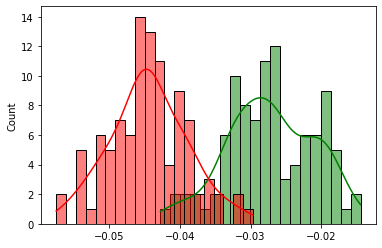

In [94]:
# Plotting the results of the XGB
sns.histplot(results_xgb_true,kde=True,bins=20,color='green')
sns.histplot(results_xgb_false,kde=True,bins=20,color='red')

<AxesSubplot:ylabel='Count'>

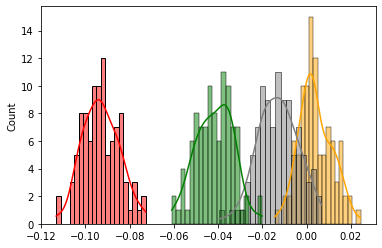

In [95]:
# Plotting the results of the XGB
sns.histplot(results_xgb_1,kde=True,bins=20,color='red')
sns.histplot(results_xgb_2,kde=True,bins=20,color='orange')
sns.histplot(results_xgb_3,kde=True,bins=20,color='grey')
sns.histplot(results_xgb_4,kde=True,bins=20,color='green')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train, 
                    y_train_cat, 
                    validation_split=0.3,
                    epochs = 5, 
                    batch_size = 16,
                    callbacks=[es],
                    verbose = 0)

In [115]:
def custom_LearningRate_schedular(epoch):
    if epoch < 5:
        return 0.01
    else:
        return 0.01 * tf.math.exp(0.1 * (10 - epoch))

In [146]:
model = xgb.XGBRegressor(max_depth=2, eta=0.01, alpha=0.001 )


parameters = {
    'subsample': [0.5, 1],
    'n_estimators': range(60, 500, 50),
    'learning_rate': [0.3, 0.2, 0.1, 0.05, 0.01],
    'gamma': [0, 1],
    'max_bin': [256, 512],
    'min_child_weight': [0, 1]
    
}
grid_search = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    n_jobs = -1,
    cv = 5,
    verbose=2
)

callback = LearningRateScheduler(custom_LearningRate_schedular)

# Fit data to Grid Search
grid_search.fit(X_train_0,y_train_0, epochs=100, callbacks=[callback], validation_data=(X_test_0, y_test_0));
grid_search.best_estimator_


Fitting 5 folds for each of 720 candidates, totalling 3600 fits


2022-06-05 18:20:10.095899: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-05 18:20:10.095899: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-05 18:20:10.095903: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-05 18:20:10.095902: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly 

[CV] END gamma=0, learning_rate=0.3, max_bin=256, min_child_weight=0, n_estimators=60, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.3, max_bin=256, min_child_weight=0, n_estimators=60, subsample=1; total time=   0.0s
[CV] END gamma=0, learning_rate=0.3, max_bin=256, min_child_weight=0, n_estimators=110, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.3, max_bin=256, min_child_weight=0, n_estimators=160, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.3, max_bin=256, min_child_weight=0, n_estimators=210, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.3, max_bin=256, min_child_weight=0, n_estimators=210, subsample=1; total time=   0.0s
[CV] END gamma=0, learning_rate=0.3, max_bin=256, min_child_weight=0, n_estimators=260, subsample=1; total time=   0.0s
[CV] END gamma=0, learning_rate=0.3, max_bin=256, min_child_weight=0, n_estimators=310, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=

[CV] END gamma=0, learning_rate=0.2, max_bin=256, min_child_weight=1, n_estimators=460, subsample=1; total time=   0.0s
[CV] END gamma=0, learning_rate=0.2, max_bin=256, min_child_weight=1, n_estimators=460, subsample=1; total time=   0.0s
[CV] END gamma=0, learning_rate=0.2, max_bin=256, min_child_weight=1, n_estimators=460, subsample=1; total time=   0.0s
[CV] END gamma=0, learning_rate=0.2, max_bin=512, min_child_weight=0, n_estimators=60, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.2, max_bin=512, min_child_weight=0, n_estimators=60, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.2, max_bin=512, min_child_weight=0, n_estimators=60, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.2, max_bin=512, min_child_weight=0, n_estimators=60, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.2, max_bin=512, min_child_weight=0, n_estimators=60, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.2

[CV] END gamma=0, learning_rate=0.1, max_bin=512, min_child_weight=1, n_estimators=60, subsample=1; total time=   0.0s
[CV] END gamma=0, learning_rate=0.1, max_bin=512, min_child_weight=1, n_estimators=110, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.1, max_bin=512, min_child_weight=1, n_estimators=110, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.1, max_bin=512, min_child_weight=1, n_estimators=110, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.1, max_bin=512, min_child_weight=1, n_estimators=110, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.1, max_bin=512, min_child_weight=1, n_estimators=110, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.1, max_bin=512, min_child_weight=1, n_estimators=110, subsample=1; total time=   0.0s
[CV] END gamma=0, learning_rate=0.1, max_bin=512, min_child_weight=1, n_estimators=110, subsample=1; total time=   0.0s
[CV] END gamma=0, learning_rate

[CV] END gamma=0, learning_rate=0.05, max_bin=256, min_child_weight=0, n_estimators=310, subsample=1; total time=   0.0s
[CV] END gamma=0, learning_rate=0.05, max_bin=256, min_child_weight=0, n_estimators=360, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.05, max_bin=256, min_child_weight=0, n_estimators=360, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.05, max_bin=256, min_child_weight=0, n_estimators=360, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.05, max_bin=256, min_child_weight=0, n_estimators=360, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.05, max_bin=512, min_child_weight=1, n_estimators=110, subsample=1; total time=   0.0s
[CV] END gamma=0, learning_rate=0.05, max_bin=512, min_child_weight=1, n_estimators=110, subsample=1; total time=   0.0s
[CV] END gamma=0, learning_rate=0.05, max_bin=512, min_child_weight=1, n_estimators=160, subsample=0.5; total time=   0.0s
[CV] END gamma=0, lear

[CV] END gamma=0, learning_rate=0.01, max_bin=256, min_child_weight=1, n_estimators=210, subsample=1; total time=   0.0s
[CV] END gamma=0, learning_rate=0.01, max_bin=256, min_child_weight=1, n_estimators=210, subsample=1; total time=   0.0s
[CV] END gamma=0, learning_rate=0.01, max_bin=256, min_child_weight=1, n_estimators=210, subsample=1; total time=   0.0s
[CV] END gamma=0, learning_rate=0.01, max_bin=256, min_child_weight=1, n_estimators=260, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.01, max_bin=256, min_child_weight=1, n_estimators=260, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.01, max_bin=256, min_child_weight=1, n_estimators=260, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.01, max_bin=256, min_child_weight=1, n_estimators=260, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.01, max_bin=256, min_child_weight=1, n_estimators=260, subsample=0.5; total time=   0.0s
[CV] END gamma=0, lear

[CV] END gamma=1, learning_rate=0.3, max_bin=512, min_child_weight=0, n_estimators=260, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.3, max_bin=512, min_child_weight=0, n_estimators=310, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.3, max_bin=512, min_child_weight=0, n_estimators=310, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.3, max_bin=512, min_child_weight=0, n_estimators=310, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.3, max_bin=512, min_child_weight=0, n_estimators=310, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.3, max_bin=512, min_child_weight=0, n_estimators=310, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.3, max_bin=512, min_child_weight=0, n_estimators=310, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.3, max_bin=512, min_child_weight=0, n_estimators=310, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rat

[CV] END gamma=1, learning_rate=0.2, max_bin=256, min_child_weight=0, n_estimators=60, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.2, max_bin=256, min_child_weight=0, n_estimators=60, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.2, max_bin=256, min_child_weight=0, n_estimators=60, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.2, max_bin=256, min_child_weight=0, n_estimators=60, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.2, max_bin=256, min_child_weight=0, n_estimators=60, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.2, max_bin=256, min_child_weight=0, n_estimators=60, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.2, max_bin=256, min_child_weight=0, n_estimators=60, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.2, max_bin=512, min_child_weight=0, n_estimators=310, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.2, 

[CV] END gamma=1, learning_rate=0.1, max_bin=512, min_child_weight=0, n_estimators=260, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.1, max_bin=512, min_child_weight=0, n_estimators=260, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.1, max_bin=512, min_child_weight=0, n_estimators=310, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.1, max_bin=512, min_child_weight=0, n_estimators=310, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.1, max_bin=512, min_child_weight=0, n_estimators=310, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.1, max_bin=512, min_child_weight=0, n_estimators=310, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.1, max_bin=512, min_child_weight=0, n_estimators=310, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.1, max_bin=512, min_child_weight=0, n_estimators=310, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rat

[CV] END gamma=1, learning_rate=0.05, max_bin=256, min_child_weight=1, n_estimators=110, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.05, max_bin=256, min_child_weight=1, n_estimators=110, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.05, max_bin=256, min_child_weight=1, n_estimators=110, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.05, max_bin=256, min_child_weight=1, n_estimators=110, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.05, max_bin=256, min_child_weight=1, n_estimators=110, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.05, max_bin=256, min_child_weight=1, n_estimators=110, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.05, max_bin=256, min_child_weight=1, n_estimators=110, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.05, max_bin=256, min_child_weight=1, n_estimators=160, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning

ValueError: 
All the 3600 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3600 fits failed with the following error:
Traceback (most recent call last):
  File "/home/joaosantos/.pyenv/versions/3.8.12/envs/OnThePitch/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/joaosantos/.pyenv/versions/3.8.12/envs/OnThePitch/lib/python3.8/site-packages/xgboost/core.py", line 532, in inner_f
    return f(**kwargs)
TypeError: fit() got an unexpected keyword argument 'epochs'


In [147]:
grid_search.best_estimator_

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

[CV] END gamma=1, learning_rate=0.01, max_bin=512, min_child_weight=1, n_estimators=60, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.01, max_bin=512, min_child_weight=1, n_estimators=60, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.01, max_bin=512, min_child_weight=1, n_estimators=60, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.01, max_bin=512, min_child_weight=1, n_estimators=160, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.01, max_bin=512, min_child_weight=1, n_estimators=160, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.01, max_bin=512, min_child_weight=1, n_estimators=160, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.01, max_bin=512, min_child_weight=1, n_estimators=260, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.01, max_bin=512, min_child_weight=1, n_estimators=310, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_

[CV] END gamma=1, learning_rate=0.01, max_bin=512, min_child_weight=1, n_estimators=160, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.01, max_bin=512, min_child_weight=1, n_estimators=210, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.01, max_bin=512, min_child_weight=1, n_estimators=310, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.01, max_bin=512, min_child_weight=1, n_estimators=310, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.01, max_bin=512, min_child_weight=1, n_estimators=310, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.01, max_bin=512, min_child_weight=1, n_estimators=410, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.01, max_bin=512, min_child_weight=1, n_estimators=410, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.01, max_bin=512, min_child_weight=1, n_estimators=410, subsample=1; total time=   0.0s
[CV] END gamma=1, learni

[CV] END gamma=1, learning_rate=0.05, max_bin=512, min_child_weight=0, n_estimators=260, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.05, max_bin=512, min_child_weight=0, n_estimators=260, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.05, max_bin=512, min_child_weight=0, n_estimators=260, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.05, max_bin=512, min_child_weight=0, n_estimators=310, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.05, max_bin=512, min_child_weight=0, n_estimators=310, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.05, max_bin=512, min_child_weight=0, n_estimators=310, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.05, max_bin=512, min_child_weight=0, n_estimators=310, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.05, max_bin=512, min_child_weight=0, n_estimators=310, subsample=0.5; total time=   0.0s
[CV] END gamma=1, lear

In [ ]:
grid_search.best_estimator_

[CV] END gamma=1, learning_rate=0.05, max_bin=512, min_child_weight=0, n_estimators=460, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.05, max_bin=512, min_child_weight=0, n_estimators=460, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_rate=0.05, max_bin=512, min_child_weight=0, n_estimators=460, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.05, max_bin=512, min_child_weight=0, n_estimators=460, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.05, max_bin=512, min_child_weight=0, n_estimators=460, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.05, max_bin=512, min_child_weight=0, n_estimators=460, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.05, max_bin=512, min_child_weight=0, n_estimators=460, subsample=1; total time=   0.0s
[CV] END gamma=1, learning_rate=0.05, max_bin=512, min_child_weight=1, n_estimators=60, subsample=0.5; total time=   0.0s
[CV] END gamma=1, learning_

# Comments regarding results of the tests we ran and Next Steps

In [ ]:
## Comments

# baseline = 0.008297694850435258 (all features)

# delta without Joao features = 0.014419296789770412 => F:-0.029970666611150436 and T:-0.015551369821380024
# --> WE REMOVE JOAO FEATURE

# delta when removing the odds buckets = -0.009317543146000251 => F:-0.022611272813043187 and T:-0.028804787343669917
# --> WE KEEP THE ODDS BUCKETS

# delta when removing the odds buckets = -0.009317543146000251 => F:-0.022611272813043187 and T:-0.028804787343669917
# --> WE KEEP THE ODDS BUCKETS

# delta when removing the countries and divisions = 0.004795286566703704
# --> WE KEEP THE COUNTRIES AND DIVISIONS

# delta when removing the divisions but keeping the countries = 0.008380480363148559 (worsening)
# delta when removing the countries but keeping the divisions = 0.02259680830123266 (best score ever)
# --> WE KEEP THE DIVSIONS AND REMOVE THE COUNTRIES

# delta when removing the 'month_after_July': 0.013657154854343441 DECREASED A LOT! We keep month after July
# year 2020_2021 = 0.012829398919170131 DECREASED A LOT! 
# TIME MATTERS!! We need months, years, time

# New basline: 0.023917075840908224

#'Pin pays better' does not improve the baseline and we remove it

#'Market_consensus' MATTERS we keep it

#VIG matters

# We should remove the P<PC variable
# BEST DELTA: 0.03151890594630853


In [ ]:
# Next steps:

## Time: Further explore how to optimise the features of time (years, months, hours, etc.)
## Odds: Further explore how to optimise the odds buckets (different bins, min-max scaling)
## VIG + Mkt Consensus: Further explore how to optimise VIG + Market consensus

# [SKIP] Other models + stats package we could use [SKIP]

In [ ]:
# Random Forest

In [ ]:
my_model = RandomForestRegressor(random_state=0).fit(X_step_joao, y)

In [ ]:
y_pred = my_model.predict(X_step_joao)

In [ ]:
# SHAP values

In [ ]:
#import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_step_joao)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, X_step_joao)

#- Vertical location shows what feature it is depicting
#- Color shows whether that feature was high or low for that row of the dataset
#- Horizontal location shows whether the effect of that value caused a higher or lower prediction.

In [ ]:
shap.summary_plot(shap_values, X_step_joao, plot_type="bar")

# Finding new features

In [16]:
for column in data.columns: 
    print(column)

Div
Date
Time
HomeTeam
AwayTeam
FTHG
FTAG
FTR
HTHG
HTAG
HTR
HS
AS
HST
AST
HF
AF
HC
AC
HY
AY
HR
AR
B365H
B365D
B365A
BWH
BWD
BWA
IWH
IWD
IWA
PSH
PSD
PSA
WHH
WHD
WHA
VCH
VCD
VCA
MaxH
MaxD
MaxA
AvgH
AvgD
AvgA
B365>2.5
B365<2.5
P>2.5
P<2.5
Max>2.5
Max<2.5
Avg>2.5
Avg<2.5
AHh
B365AHH
B365AHA
PAHH
PAHA
MaxAHH
MaxAHA
AvgAHH
AvgAHA
B365CH
B365CD
B365CA
BWCH
BWCD
BWCA
IWCH
IWCD
IWCA
PSCH
PSCD
PSCA
WHCH
WHCD
WHCA
VCCH
VCCD
VCCA
MaxCH
MaxCD
MaxCA
AvgCH
AvgCD
AvgCA
B365C>2.5
B365C<2.5
PC>2.5
PC<2.5
MaxC>2.5
MaxC<2.5
AvgC>2.5
AvgC<2.5
AHCh
B365CAHH
B365CAHA
PCAHH
PCAHA
MaxCAHH
MaxCAHA
AvgCAHH
AvgCAHA
Unnamed: 106
nb_goals
over_2.5_goals
under_2.5_goals
payout_avg_under_2.5
payout_avg_over_2.5
payout_under_2.5_pinacle
payout_over_2.5_pinacle
payout_under_2.5_365
payout_over_2.5_365
payout_avg_under_closing_2.5
payout_avg_over_closing_2.5
payout_under_2.5_pinacle_closing
payout_over_2.5_pinacle_closing
payout_under_2.5_365_closing
payout_over_2.5_365_closing
Implied Probability <2.5 avg
Implied Proba